Epoch: 0, Loss: 0.03652799874544144
Epoch: 1, Loss: 0.025563301518559456
Epoch: 2, Loss: 0.020777029916644096
Epoch: 3, Loss: 0.017944421619176865
Epoch: 4, Loss: 0.01602013222873211
Epoch: 5, Loss: 0.014604249969124794
Epoch: 6, Loss: 0.013506483286619186
Epoch: 7, Loss: 0.012623286806046963
Epoch: 8, Loss: 0.011892877519130707
Epoch: 9, Loss: 0.011275766417384148


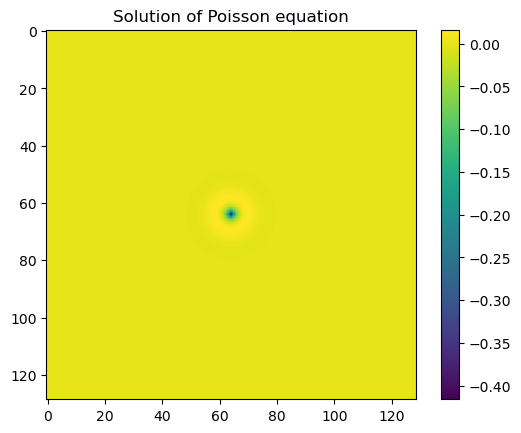

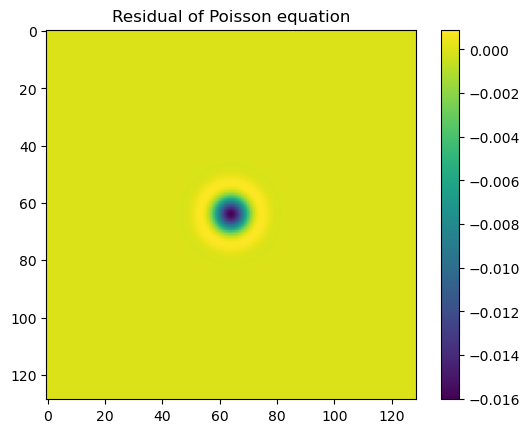

In [60]:
import jax
import jax.numpy as jnp

# Define the Poisson equation function
def poisson_eqn(u, f, h):
    x = jnp.arange(0, u.shape[0])
    y = jnp.arange(0, u.shape[1])
    x, y = jnp.meshgrid(x, y)

    bound = (x == 0) | (x == u.shape[0]-1) | (y == 0) | (y == u.shape[1]-1)

    def poisson_eqn(i, j, b):
        return b * u[i, j] + (1 - b) * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - 4 * u[i, j] - f[i, j])
    
    return jax.vmap(poisson_eqn)(x, y, bound)

def poisson_loss(u, f, h):
    return jnp.sum(jnp.square(poisson_eqn(u, f, h)))

def poisson_loss_grad(u, f, h):
    return jax.grad(poisson_loss)(u, f, h)

def poisson_optimization(u, f, h, lr=0.1, epoch=10, num_iters=100):
    for i in range(epoch):
        for _ in range(num_iters):
            u = u - lr * poisson_loss_grad(u, f, h)
        print('Epoch: {}, Loss: {}'.format(i, poisson_loss(u, f, h)))
    return u

# Define the 2D Jacobi iterative solver function
def jacobi_solver(u, f, h, epoch=10, num_iters=50):
    x = jnp.arange(0, u.shape[0])
    y = jnp.arange(0, u.shape[1])
    x, y = jnp.meshgrid(x, y)

    bound = (x == 0) | (x == u.shape[0]-1) | (y == 0) | (y == u.shape[1]-1)

    def jacobi_iteration(i, j, b):
        return b * u[i, j] + (1 - b) * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j])*0.25

    for i in range(epoch):
        for _ in range(num_iters):
            u = jax.vmap(jacobi_iteration)(x, y, bound)
        print('Epoch: {}, Residual: {}'.format(i, jnp.sum(jnp.abs(poisson_eqn(u, f, h)))))

    return u



# Set up the problem parameters
nx = 129
ny = 129

x = jnp.arange(0, nx)
y = jnp.arange(0, ny)
x, y = jnp.meshgrid(x, y)

# Initialize the solution u
u = jnp.zeros((nx, ny))

# Initialize the source f
f = jnp.zeros((nx, ny))
f = f.at[64, 64].set(1)

# Solve the Poisson equation using Jacobi iterative solver
u = poisson_optimization(u, f, 1, epoch=10, num_iters=100)

# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(u, f, h)

# plot the solution
import matplotlib.pyplot as plt
plt.imshow(u)
plt.colorbar()
#set title
plt.title('Solution of Poisson equation')
plt.show()

# plot the residual
plt.imshow(residual)
plt.colorbar()
#set title
plt.title('Residual of Poisson equation')
plt.show()



In [3]:
# Define the grid
dx = 1.0
u = jnp.zeros((100, 100))
f = jnp.zeros((100, 100))
f = jax.ops.index_update(f, (50, 50), 1.0)

# Solve the Poisson equation
u = jacobi_poisson(u, f, dx, 1000)

# Plot the solution
import matplotlib.pyplot as plt
plt.imshow(u)
plt.show()

AttributeError: module 'jax.ops' has no attribute 'index_update'

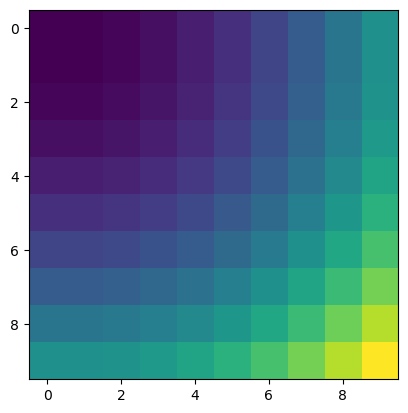

In [17]:
import jax
import jax.numpy as jnp

# create a meshgrid of x and y values
x = jnp.arange(0, 10)
y = jnp.arange(0, 10)
x, y = jnp.meshgrid(x, y)

# create a batch of input values
u = (x - 0.5)**2 + (y - 0.5)**2

def f(i, j):
    return u[i,j] + 0*i + 0*j

# Apply the function f to the batch of input values using vmap
f_batch = jax.vmap(f)(x, y)

# plot the results
import matplotlib.pyplot as plt
plt.imshow(f_batch)
plt.show()